# Mask R-CNN - Train on Fashion Dataset


This notebook shows how to train Mask R-CNN on the Fashion dataset. 

The code of the *Fashion* dataset is included below. A maskrcnn.utils.DataSet object is customized for the Fashion dataset.  This object is used to train the model.

NOTE: install:

https://github.com/cocodataset/cocoapi

After cloning, navigate to the PythonAPI directory and run 'make'.

Then, 'python setup.py build_ext install' from the same directory.

## Set Backend For GPU Support
This can be commented out if an Nvidia GPU is being used

In [3]:
import os
# # fix libiomp5.dylib error for mac
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
# OPTIONAL SETTING
# Here we override the keras backend env variable to use plaidml
# plaidml can make use of AMD GPUs 
# This assignment needs to be added before loading keras libraries

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# to install plaidML, activate appropriate environment and then:
#   pip install -U plaidml-keras
#   plaidml-setup

In [5]:
# import matplotlib.pyplot as plt
# import numpy as np
# import keras
# keras.__version__

### Load Modules

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from mrcnn.visualize import display_images

%matplotlib inline 


Using plaidml.keras.backend backend.


### To add Tensorboard capability to a model: <br>
**`name = "Name of training model"`** <br>
**`tensorboard = TensorBoard(log_dir="logs/{}".format(name))`** <br>
<br>
in the training step, include **`callback=[tensorboard]`** argument.

To open tensorboard, from terminal: <br>

**`tensorboard --logdir="<path to logs directory>"`**

### Setup local variables

In [7]:
data_dir    = '../../../data/FashionDataSet/'
train_dir   = os.path.join(data_dir, 'train')
images_file = os.path.join(data_dir, 'train.csv' )
cat_file    = os.path.join(data_dir, 'label_descriptions.json' )

In [8]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(data_dir, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(data_dir, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [9]:
# !pip install ipywidgets 
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

# %%capture
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import skimage
import random
# from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from pycocotools.coco import maskUtils


## Configurations

In [10]:
class FashionConfig(Config):
    """
    Configuration for training on the fashion dataset.
    Derives from the base Config class and overrides values specific
    to the fashion dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fashion"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #can change this

    # Number of classes (including background)
    NUM_CLASSES = 1 + 46  # background + 46 fashion categories
    
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [11]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [12]:
import pickle

# Use pickle to save history for later use
def pickle_save(variable, save_dir, pickel_fileName):
#     cwd = os.getcwd()
#     Save_dir = cwd + '//pickle//'
    save_file = save_dir + pickel_fileName
    if os.path.isdir(save_dir) == 0:
        os.mkdir(save_dir)
    with open(save_file, 'wb') as f:
        pickle.dump(variable, f)


# Loading a prevously saved pickle file
def pickle_load(save_dir, pickel_fileName):
#     cwd = os.getcwd()
#     pickle_file = cwd + '//pickle//' + pickel_fileName
    # Getting back the data:
    pickle_filepath = os.path.join(save_dir, pickel_fileName)
    with open(pickle_filepath, 'rb') as f:
        history = pickle.load(f)
        return history

## Dataset

Create a dataset object to use with Mask_RCNN. <br>
https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

in the COCO object, image_info is a dictionary with keys:<br>
    image_info = {'info':info, <br>
                  'licenses':licenses, <br>
                  'images':images,<br>
                  'annotations':annotations,<br>
                  'categories':categories}<br>
                  
Dataset Methods: <br>
#### Bounding Boxes
- extract_bboxes(mask)
- compute_iou(box, boxes, box_area, boxes_area)
- compute_overlaps(boxes1, boxes2)
- compute_overlaps_masks(masks1, masks2)
- non_max_suppression(boxes, scores, threshold)
- apply_box_deltas(boxes, deltas)
- box_refinement_graph(box, gt_box)
- box_refinement(box, gt_box)

#### Dataset Class
- class Dataset(object):
- __init__(self, class_map=None)
- def add_class(self, source, class_id, class_name)
- add_image(self, source, image_id, path, **kwargs)
- image_reference(self, image_id)
- prepare(self, class_map=None)
- map_source_class_id(self, source_class_id)
- get_source_class_id(self, class_id, source)
- @property image_ids(self)
- source_image_link(self, image_id)
- load_image(self, image_id)
- load_mask(self, image_id)
- resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square")
- resize_mask(mask, scale, padding, crop=None)
- minimize_mask(bbox, mask, mini_shape)
- expand_mask(bbox, mini_mask, image_shape)
- unmold_mask(mask, bbox, image_shape)

#### Anchors
- generate_anchors(scales, ratios, shape, feature_stride, anchor_stride)
- generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,anchor_stride)

#### Miscellaneous
- trim_zeros(x)
- compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0)
- compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5)
- compute_ap_range(gt_box, gt_class_id, gt_mask,
                     pred_box, pred_class_id, pred_score, pred_mask,
                     iou_thresholds=None, verbose=1)
- compute_recall(pred_boxes, gt_boxes, iou)


#### Batch Slicing
- batch_slice(inputs, graph_fn, batch_size, names=None)
- download_trained_weights(coco_model_path, verbose=1)
- norm_boxes(boxes, shape)
- denorm_boxes(boxes, shape)
- resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None)



## Build the FashionDataset object -- based on the CocoDataset Object

After instantiating a new instance of FashionDataset:
- 1) add method to create classes: create_classes(self, cat_file:str)
- 2) Add image info with add_image()
- 3) implement image_reference()
- 4) implement load_image()


In [13]:
class FashionDataset(utils.Dataset):
    
    @staticmethod
    def load(filepath:str):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            return data
        
    def save(self, filepath:str):
        with open(save_file, 'wb') as f:
            pickle.dump(self, filepath)
            
    def __len__(self):
        return len(self.image_info)
    
    def __init__(self):
        super(FashionDataset, self).__init__()  
        self.class_names= []
    
    def create_classes(self, cat_file:str) -> [dict]:
        """
        Added to FashionDataset.
        Initialize the classes.
        param:cat_file - filepath to fashion dataset's label_descriptions.json file
        """
        # read labels file
        with open(cat_file, 'r') as data_file:
            data=data_file.read()

        # parse file
        labels = json.loads(data)

        categories = labels.get('categories')
        df_categories = pd.DataFrame(categories)
        df_categories['source'] = "imaterialist"

        dict_categories = [dict(x[1]) for x in df_categories.iterrows()]

        for c in dict_categories:
            self.add_class(c['source'], c['id']+1, c['name']) # add 1 to make room for background

        print ("{} classes added.".format(len(dict_categories)))

        return dict_categories
    
    
    def create_anns(self, sub_df_images:pd.DataFrame) -> dict:
        """
        Creates an 'annotations' entry in an image's image_info entry.
        dict_keys(['id', 'image_id', 'segmentation', 'category_id', 'area', 'iscrowd', 'bbox']
        """
        annotations = []
        
        for mask in sub_df_images.iterrows():
            h      = int(mask[1].Height)
            w      = int(mask[1].Width)
            counts = np.fromstring(mask[1].EncodedPixels, dtype=int, sep=" ")
            ann_dict = {'id'            : mask[0], 
                        'image_id'      : mask[1].ImageId, 
                        'segmentation'  : {'counts' : counts, 'size': [h, w] }, 
                        'category_id'   : int(mask[1].ClassId.split('_')[0])+1, # add 1 to make room for background
                        'iscrowd'       : True, # True indicates the use of uncompressed RLE
                        'bbox'          : [] }

            annotations.append(ann_dict)
            
        return annotations
        
    
    def create_images(self, images_file:str, train_dir:str, imgids:list=None, limit:int=None) -> (dict, pd.DataFrame):
        """
        Build the image_info['images'] dictionary element with all images.
        If imgids list is None, all images in the images_file will be included, otherwise,
        only the imgids in the list will be included.
        """
        
        df_images = pd.read_csv(images_file, nrows=limit)
        
        # restrict the dataframe to items in imgids list, if list is provided
        if imgids is not None:
            df_images = df_images[df_images.ImageId.isin(imgids)]
        
        
        
#         df_images.rename(columns={"ImageId":'file_name', "Height":'height', "Width":'width'}, inplace=True)
#         df_images['id'] = [x for x in range(len(df_images))]
#         df_images['source'] = 'imaterialist'
        
        df_images_unique = df_images.drop_duplicates('ImageId')
#         dict_images = [dict(x[1]) for x in tqdm(df_images_unique.iterrows(), desc="Create images dict", total=len(df_images))]
        
        
        for image in tqdm(df_images_unique.iterrows(), desc="Add images to object"):
#         for image in tqdm(dict_images, desc="Add images to object"):
#             file_path = os.path.join(train_dir,image[1].ImageId)
            self.add_image(source       = 'imaterialist', 
                           image_id     = image[0],
                           path         = os.path.join(train_dir,image[1].ImageId), 
                           height       = image[1].Height,
                           width        = image[1].Width,
                           file_name    = image[1].ImageId,
                           annotations  = self.create_anns(df_images[df_images.ImageId==image[1].ImageId]))
            
        print("Added {} images.".format(len(df_images_unique)))
        print("Added {} annotations.".format(len(df_images)))

        return self.image_info
    
    
    def load_image(self, image_id):
        """
        Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
    
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        image_info = self.image_info[image_id]

        instance_masks = []
        class_ids = []
        
        # returns list of masks/annotations for the image
        annotations = self.image_info[image_id]["annotations"] 
        
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id'] # one of 46 categories
            
            if class_id:
                # passes an element of the annotations list - this is a single mask entry
#                 m = self.annToMask(annotation, image_info["height"], image_info["width"])

                # updated to reflect problems with original maskutils implementtaion of decode
                m = self.kaggle_rle_decode(annotation, image_info["height"], image_info["width"])
                
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
#                     class_id *= -1  # mark: not sure why this was done so commetning it out
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        # assume user provided the integer id of the image
        for img in self.image_info:
            if img['id'] == image_id:
                return img['path']

        # check if the user entered the file name
        for img in self.image_info:
            if img['file_name'] == image_id:
                return img['path']
        
        print ("Image '{}' not found.".format(image_id))
        return None

    
    def kaggle_rle_decode(self, ann, h, w):
        """
        https://github.com/amirassov/kaggle-imaterialist/blob/master/src/rle.py
        Takes uncompressed RLE for a single mask.  Returns binary mask.
        param: ann - annotation including uncompressed rle in ['segmentation']['counts'] 
        -- where counts is a list of integers.  Also includes 'size' which is a list [int(h), int(w)] 
        """
        rle = ann['segmentation']['counts']
        
        starts, lengths = map(np.asarray, (rle[::2], rle[1::2]))
        starts -= 1
        ends = starts + lengths
        img = np.zeros(h * w, dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape((w, h)).T

In [14]:
def create_train_val_datasets(images_file:str, 
                              cat_file:str, 
                              split:float=0.8, 
                              limit:int=None) -> (FashionDataset,FashionDataset):
    """
    Returns a train and a val dataset object.
    If limit is None, all entries in file will be used as the population.
    """
    # split the train.csv file into train and val dataframes
    df_images = pd.read_csv(images_file, nrows=limit)
    
    # OPTN1: split so that some images will have some annotations in train and others in val
#     df_train, df_val = train_test_split(df_images , train_size=split)
    
    # OPTN2: split to that images' annotations are not in different sets
    image_filenames = np.unique(df_images.ImageId)
    train_imgids, val_imgids = train_test_split(image_filenames , train_size=.8)
    
    # Create empty objects
    fash_train = FashionDataset()
    fash_val = FashionDataset()
    
    # build classes in dataset objects
    train_classes = fash_train.create_classes(cat_file) # takes seconds
    val_classes   = fash_val.create_classes(cat_file)   # takes seconds
    
    # load image references and masks into dataset objects
    print("Building trainig dataset...")
    train_image_info = fash_train.create_images( images_file, train_dir, train_imgids, limit=limit) 
    print("Building validation dataset...")
    val_image_info   = fash_val.create_images(   images_file, train_dir, val_imgids,   limit=limit) 
    
    fash_train.prepare()
    fash_val.prepare()
    
    return fash_train, fash_val

### Load FasionDataset Objects
If you have saved the datasets, you can load them, it resplit and build them again.

In [15]:
# fash_train = pickle_load(data_dir, 'fashion_train_dataset_10k.pkl')
fash_val = pickle_load(data_dir, 'fashion_val_dataset_10k.pkl')

In [20]:
len(fash_train.image_ids), len(fash_val.image_ids)

NameError: name 'fash_train' is not defined

In [16]:
images_file

'../../../data/FashionDataSet/train.csv'

### Create FasionDataset Objects

In [29]:
# NOTE: There are 300k line images in the full training list
fash_train, fash_val = create_train_val_datasets( images_file, 
                                                  cat_file, 
                                                  split=0.8, 
                                                  limit=100000)

pickle_save(fash_train, data_dir, 'fashion_train_dataset_100k.pkl')
pickle_save(fash_val, data_dir, 'fashion_val_dataset_100k.pkl')

In [30]:
len(fash_train.image_ids), len(fash_val.image_ids)

(10975, 2744)

## Display Samples

Load and display images and masks.

In [18]:
dataset=fash_val

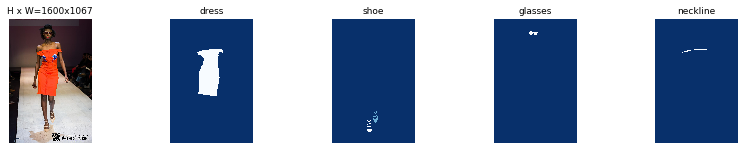

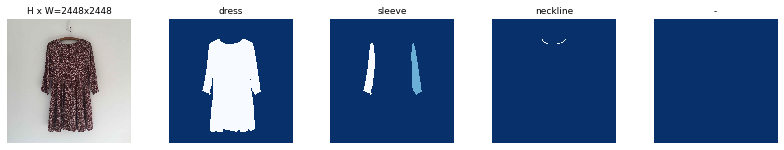

In [19]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 2)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
#     class_ids *= -1
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

Image '504' not found.
image_id  504 None
image                    shape: (1600, 1067, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1600, 1067, 16)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (16,)                 min:    2.00000  max:   36.00000  int32
bbox                     shape: (16, 4)               min:  247.00000  max: 1599.00000  int32


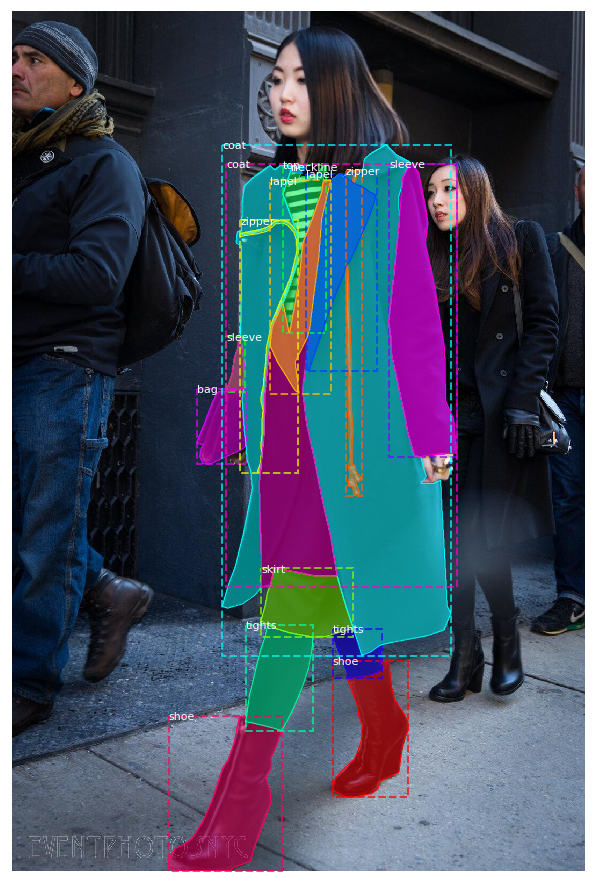

In [20]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

Image '535' not found.
image_id:  535 None
Original shape:  (3000, 1997, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 26)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (26,)                 min:    2.00000  max:   38.00000  int32
bbox                     shape: (26, 4)               min:  101.00000  max:  940.00000  int32


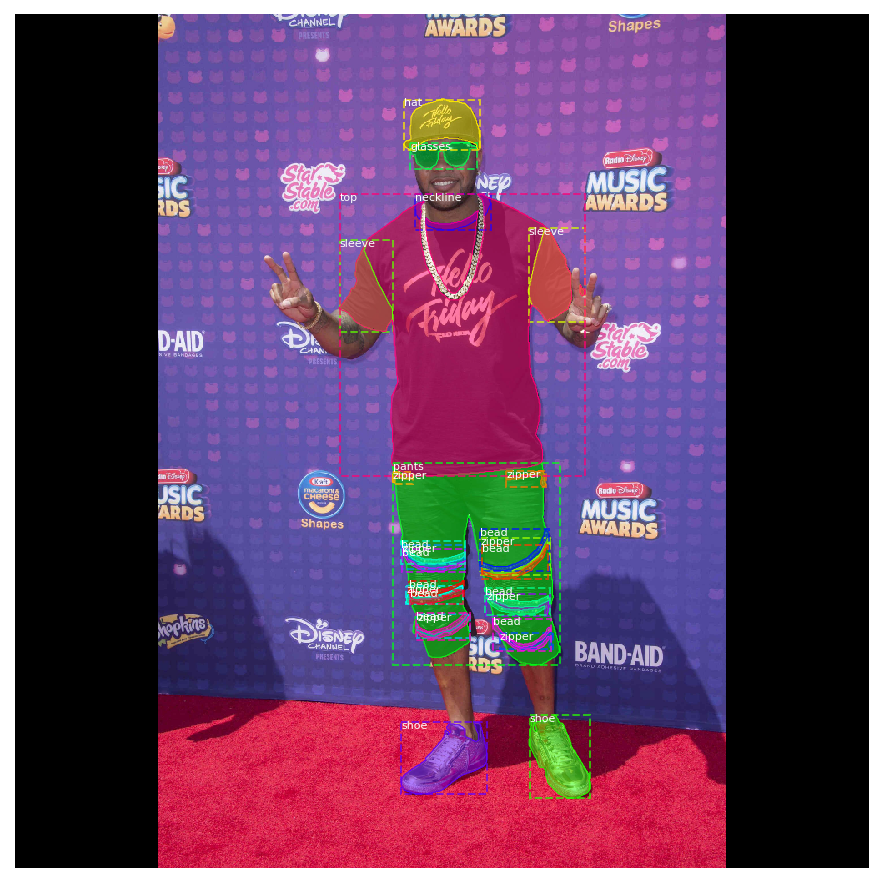

In [21]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (59,)                 min:    0.00000  max: 4912.00000  float64
class_ids                shape: (9,)                  min:    2.00000  max:   34.00000  int32
bbox                     shape: (9, 4)                min:  253.00000  max:  832.00000  int32
mask                     shape: (1024, 1024, 9)       min:    0.00000  max:    1.00000  bool


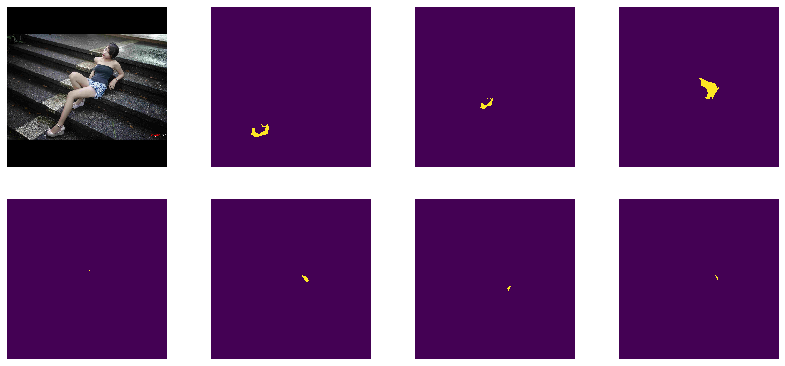

In [70]:
image_id = 409 #np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

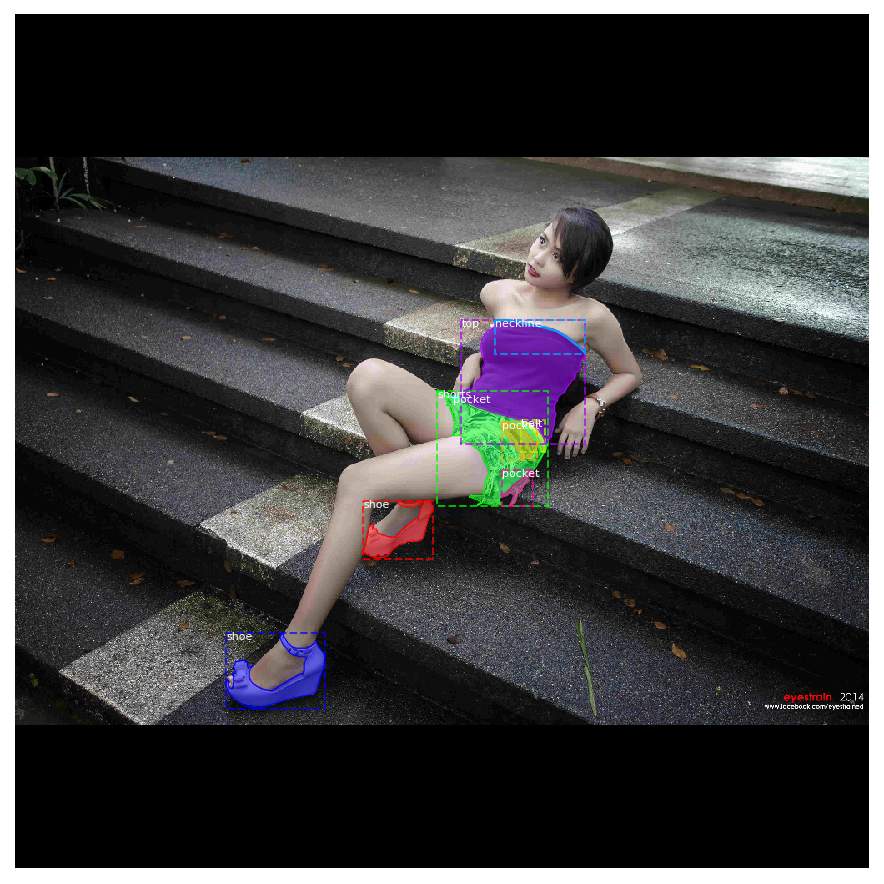

In [73]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 13)          min:    0.00000  max:    1.00000  bool


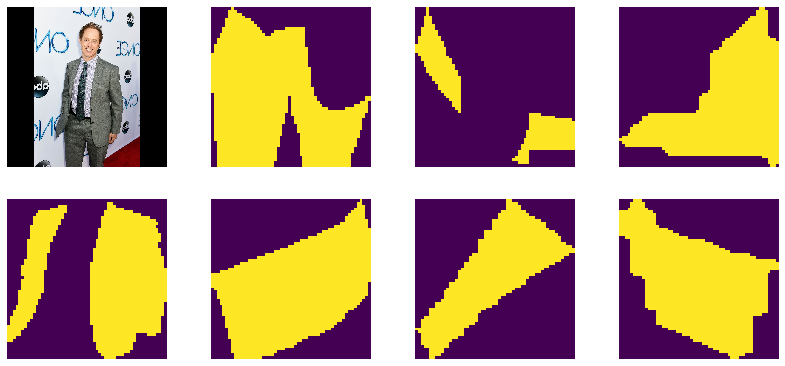

In [24]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

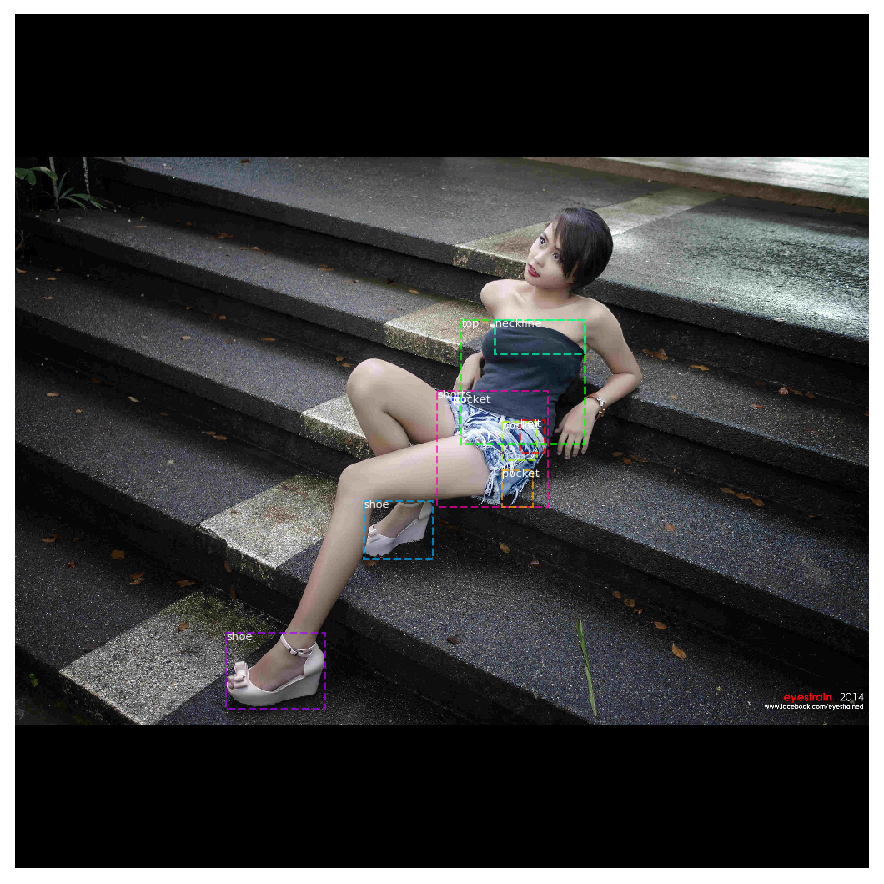

In [67]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

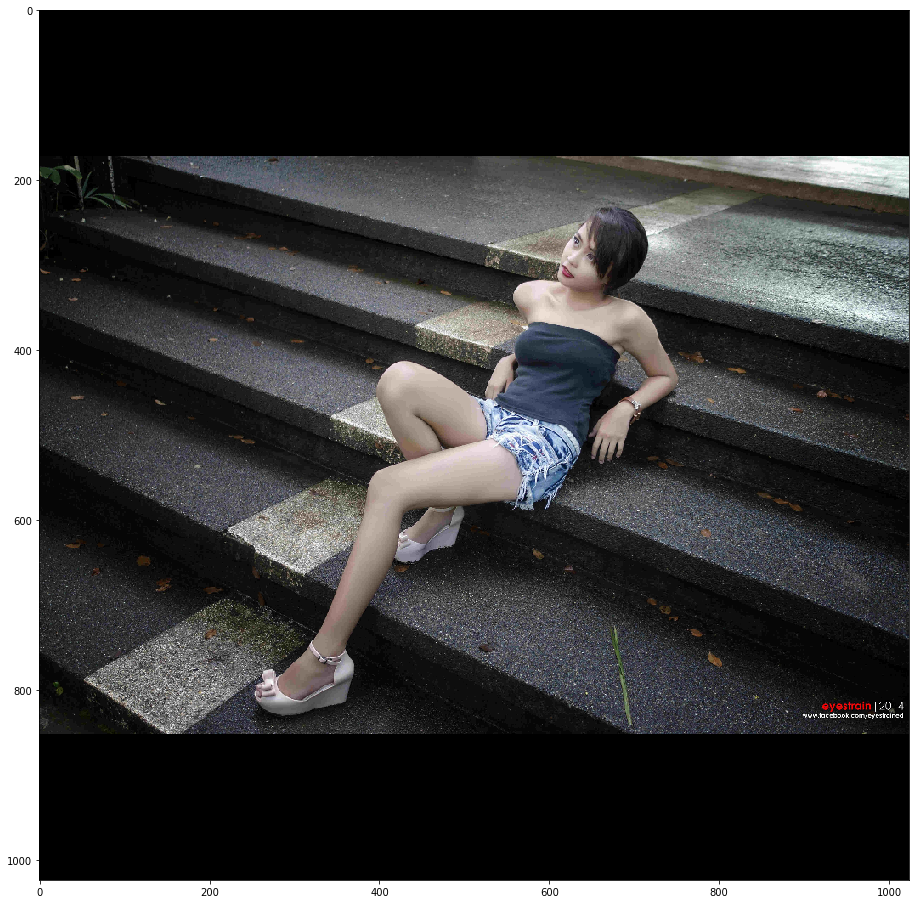

In [65]:
plt.figure(figsize=(16,16))
plt.imshow(image)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature map of the first layer is 256x256, which generates about 200K anchors (256x256x3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [42]:
backbone_shapes[1]

array([128, 128])

In [39]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


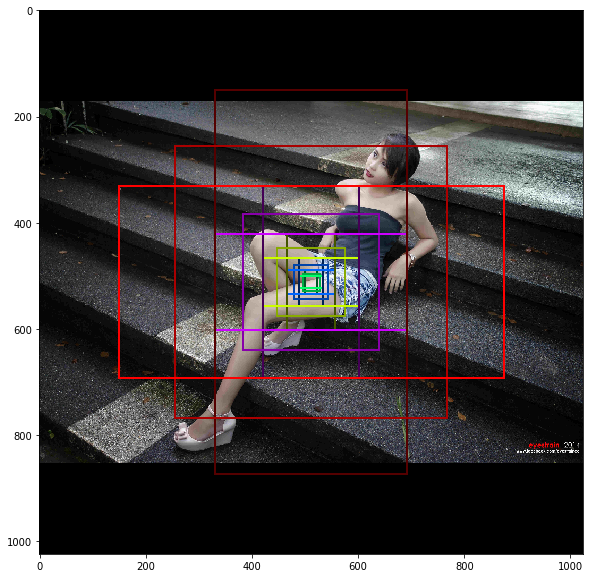

In [57]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)


fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)



## Data Generator

In [44]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
                            dataset, config, shuffle=True, random_rois=random_rois, 
                            batch_size=4,
                            detection_targets=True)

In [45]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [46]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    0.00000  max: 1022.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:   34.00000  int32
mrcnn_bbox               shape: (4, 200, 47, 4)       min:   -3.53141  max:    3.22086  float32
mrcnn_mask               shape: (4, 200, 28, 28, 47)  min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:   34.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max: 1023.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -7.54862  max:    4.99023  float64
Image '409' not found.
image_id:  409 None


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (52, 4)               min:  253.00000  max:  833.00000  float32
Positive anchors: 52
Negative anchors: 204
Neutral anchors: 261632
BG                     : 167
top                    : 6
shorts                 : 6
belt                   : 1
shoe                   : 2
pocket                 : 15
neckline               : 3


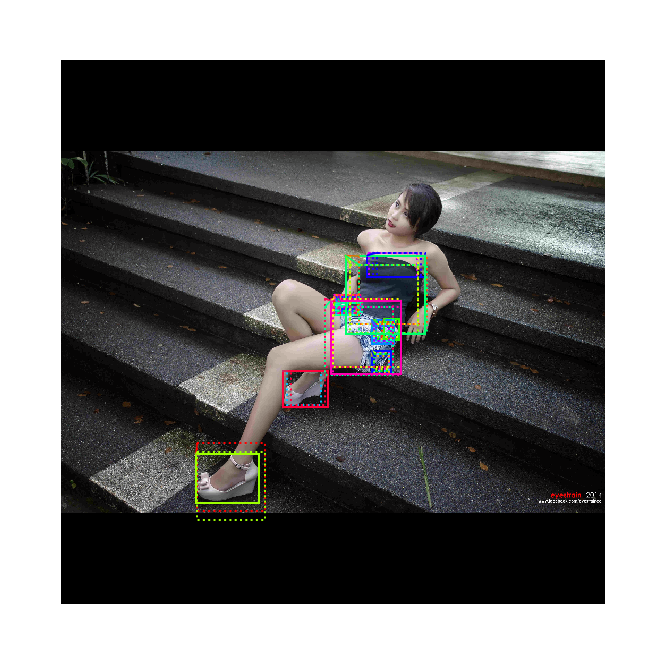

In [47]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

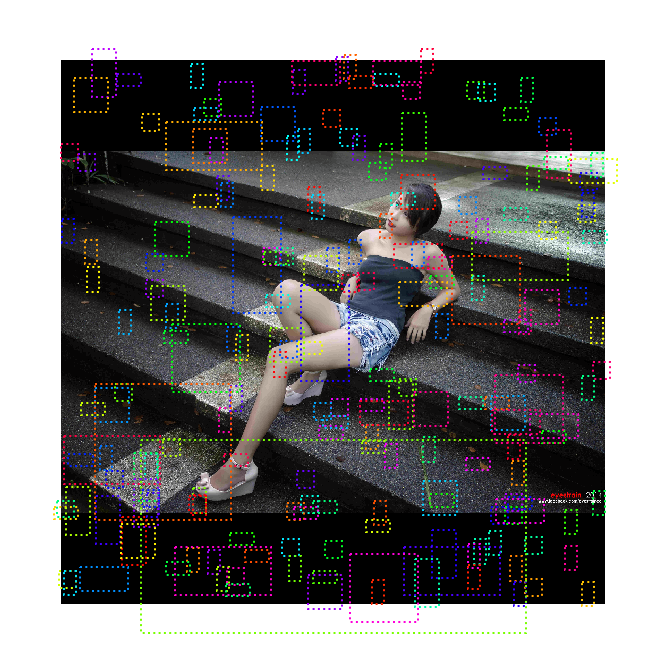

In [49]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

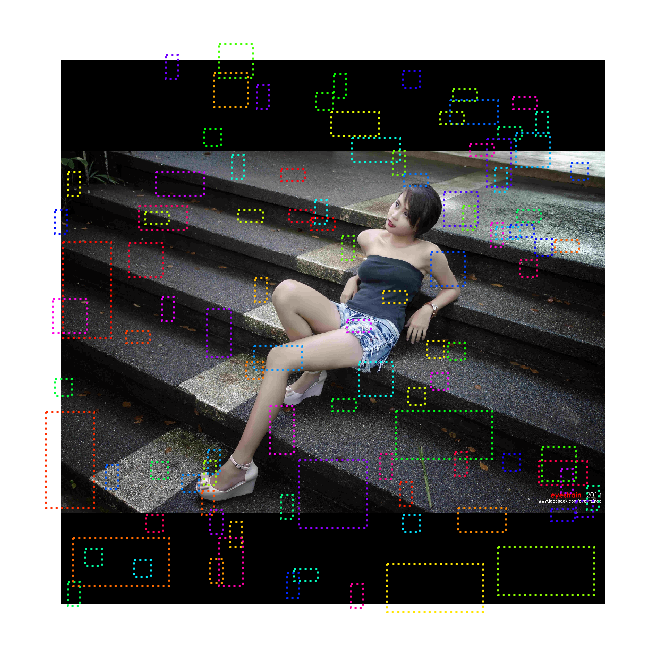

In [53]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  33
Negative ROIs:  167
Positive Ratio: 0.17
Unique ROIs: 200 out of 200


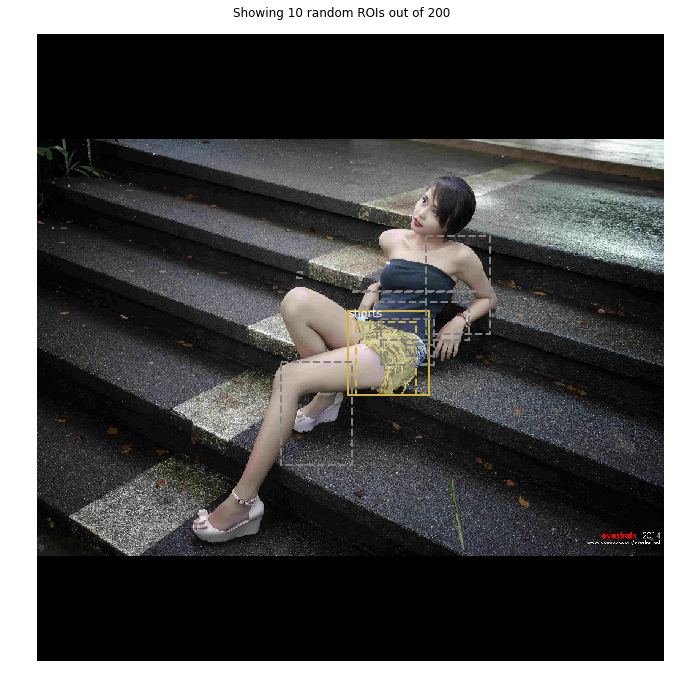

In [54]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

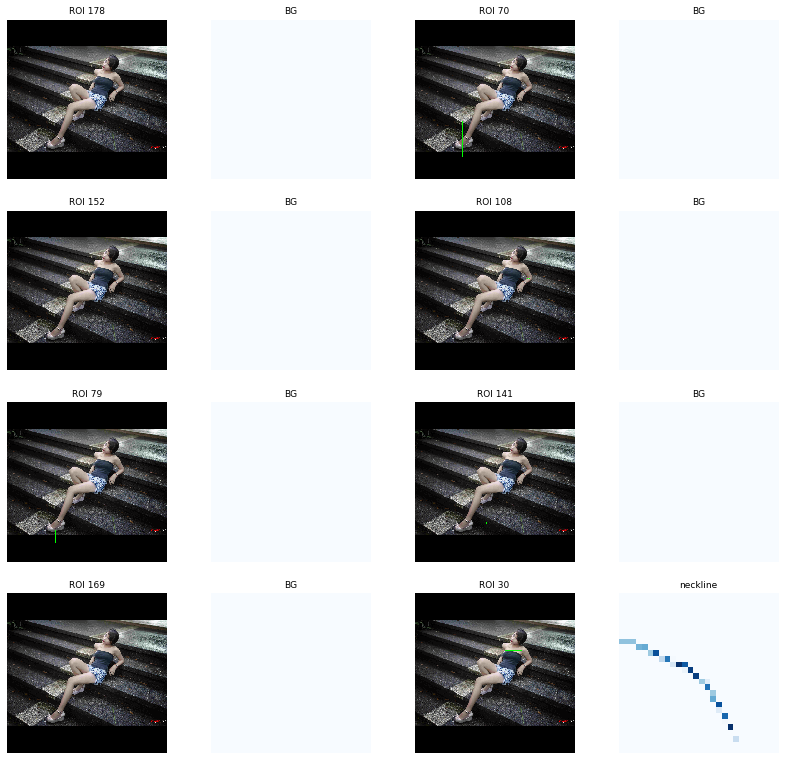

In [55]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [56]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
                                    dataset, config, shuffle=True, random_rois=10000, 
                                    batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


# Train

## Create Model

In [74]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

ValueError: Unrecognized Numpy dtype <dtype: 'int32'>

In [36]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all"` to train all layers.

In [37]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(fash_train, fash_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../../data/FashionDataSet/logs/fashion20191111T0757/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcn

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.


# model.train(fash_train, fash_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=2, 
#             layers="all")

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [21]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  ../../data/FashionDataSet/logs/fashion20191111T0757/mask_rcnn_fashion_0001.h5
Re-starting from epoch 1


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (59,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (7,)                  min:    2.00000  max:   44.00000  int32
gt_bbox                  shape: (7, 4)                min:  227.00000  max:  871.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


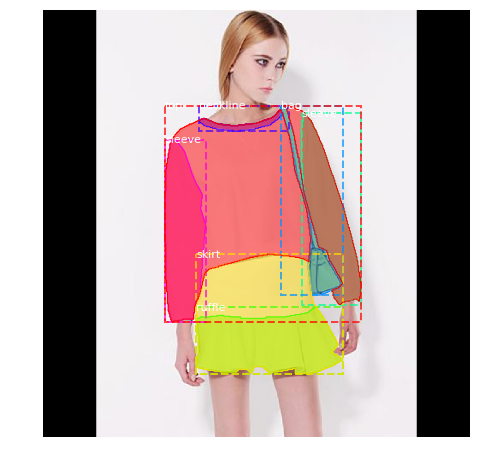

In [26]:
# Test on a random image

# show the original image
image_id = random.choice(fash_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(fash_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            fash_val.class_names, figsize=(8, 8))  # NOTE: original solution got values of class_names from train set

In [ ]:
# show inferred mask of same image
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            fash_val.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
